# **Bitcoin Forecasting**

## Setup

In [ ]:
# %tensorflow_version 1.x

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Importing data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv.zip ./
!cp /content/drive/MyDrive/Colab\ Notebooks/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv.zip ./

In [ ]:
# optional - if previous cells didn't work
#from google.colab import files
#uploaded = files.upload()

In [ ]:
!unzip "./bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv.zip"
!unzip "./coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv.zip"

Archive:  ./bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv.zip
  inflating: bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv  
Archive:  ./coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv.zip
  inflating: coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv  


In [ ]:
csv_path_bitstamp = "./bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv"
csv_path_coinbase = "./coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv"
df_bitstamp = pd.read_csv(csv_path_bitstamp)
df_coinbase = pd.read_csv(csv_path_coinbase)

In [ ]:
df_bitstamp.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_coinbase.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
columns_to_drop = ["Open", "High",	"Low",	"Volume_(BTC)",	"Volume_(Currency)",	"Weighted_Price"]
df_bitstamp.drop([col for col in columns_to_drop if col in df_bitstamp.columns], axis=1, inplace=True)
df_coinbase.drop([col for col in columns_to_drop if col in df_coinbase.columns], axis=1, inplace=True)
# df_bitstamp.dropna(inplace=True)
# df_coinbase.dropna(inplace=True)

In [ ]:
df_bitstamp['Timestamp'] = pd.to_datetime(df_bitstamp["Timestamp"], unit='s')
df_coinbase['Timestamp'] = pd.to_datetime(df_coinbase["Timestamp"], unit='s')
df_bitstamp.rename(columns={'Timestamp': 'Datetime'}, inplace=True)
df_coinbase.rename(columns={'Timestamp': 'Datetime'}, inplace=True)
# df['Timestamp'] = pd.to_datetime(df["Timestamp"], unit='s')
# df.rename(columns={'Timestamp': 'Datetime'}, inplace=True)

In [ ]:
# Setting the datetime as the index
df_bitstamp.set_index('Datetime', inplace=True)
df_coinbase.set_index('Datetime', inplace=True)

In [ ]:
df_bitstamp_summary = df_bitstamp.groupby([(df_bitstamp.index.year)]).count()
df_bitstamp_summary

,Close
Datetime,
2011,4
2012,26629
2013,319761
2014,398176
2015,372735
2016,352099
2017,483332
2018,505773
2019,508340


In [ ]:
df_coinbase_summary = df_coinbase.groupby([(df_coinbase.index.year)]).count()
df_coinbase_summary

,Close
Datetime,
2014,27
2015,440516
2016,501586
2017,514769
2018,523827
2019,9966


In [ ]:
# Compare the number of rows in each dataset for the comparable years
# if the summary is positive then coinbase is more populated, bitstamp otherwise
df_compare_summary = df_coinbase_summary.iloc[1:-1].join(df_bitstamp_summary, how='left', rsuffix='_bitstamp')
df_compare_summary['Diff'] = df_compare_summary['Close'] - df_compare_summary['Close_bitstamp']
summary = df_compare_summary['Diff'].sum()

In [ ]:
# Compare the quantity of NaNs in each dataset
df_bitstamp_na = df_bitstamp.loc[~df_bitstamp['Close'].notna()].copy()
df_bitstamp_na.fillna(1, inplace=True)
df_bitstamp_na = df_bitstamp_na.groupby([(df_bitstamp_na.index.year)]).count()
df_coinbase_na = df_coinbase.loc[~df_coinbase['Close'].notna()].copy()
df_coinbase_na.fillna(1, inplace=True)
df_coinbase_na = df_coinbase_na.groupby([(df_coinbase_na.index.year)]).count()
df_compare_na = df_coinbase_na.iloc[1:-1].join(df_bitstamp_na, how='left', rsuffix='_bitstamp')
df_compare_na['Diff'] = df_compare_na['Close_bitstamp'] - df_compare_na['Close']
total_na = df_compare_na['Diff'].sum()

In [ ]:
if summary + total_na >= 0:
  selected_dataset = df_coinbase
else:
  selected_dataset = df_bitstamp

In [ ]:
selected_dataset

,Close
Datetime,
2014-12-01 05:33:00,300.00
2014-12-01 05:34:00,NaN
2014-12-01 05:35:00,NaN
2014-12-01 05:36:00,NaN
2014-12-01 05:37:00,NaN
...,...
2019-01-07 22:02:00,4006.01
2019-01-07 22:03:00,4006.01
2019-01-07 22:04:00,4006.01


In [ ]:
init_d = selected_dataset.index[0]
end_d = selected_dataset.index[-1]
datetime_index = pd.date_range(init_d, end_d, freq='T')
df = pd.DataFrame(index=datetime_index)

In [ ]:
df = df.join(selected_dataset, how='left')

In [ ]:
df['Close'].fillna(method='ffill', inplace=True)

In [ ]:
df.head(50)

,Close
2014-12-01 05:33:00,300.0
2014-12-01 05:34:00,300.0
2014-12-01 05:35:00,300.0
2014-12-01 05:36:00,300.0
2014-12-01 05:37:00,300.0
2014-12-01 05:38:00,300.0
2014-12-01 05:39:00,300.0
2014-12-01 05:40:00,300.0
2014-12-01 05:41:00,300.0
2014-12-01 05:42:00,300.0


In [ ]:
#df = df[df.index.year != 2014]
#df = df[df.index.year != 2019]
df.groupby([(df.index.year)]).count()

,Close
2014,44307
2015,525600
2016,527040
2017,525600
2018,525600
2019,9967


In [ ]:
df['Datetime'] = df.index
# df[::60]

In [ ]:
df = df.groupby([(df.index.year), (df.index.month),(df.index.day), (df.index.hour)]).last()
df.set_index('Datetime', inplace=True)

In [ ]:
df.head()

,Close
Datetime,
2014-12-01 05:59:00,300.0
2014-12-01 06:59:00,370.0
2014-12-01 07:59:00,370.0
2014-12-01 08:59:00,370.0
2014-12-01 09:59:00,370.0


In [ ]:
# Delete the first Nan values
#df = df[df.first_valid_index():]

In [ ]:
# df['Close'].update(df_coinbase['Close'])
# df.index.name = 'Datetime'
df.reset_index(level=0, inplace=True)

In [ ]:
assert df.index.duplicated().sum() == 0

In [ ]:
df.head(50)

,Datetime,Close
0,2014-12-01 05:59:00,300.0
1,2014-12-01 06:59:00,370.0
2,2014-12-01 07:59:00,370.0
3,2014-12-01 08:59:00,370.0
4,2014-12-01 09:59:00,370.0
5,2014-12-01 10:59:00,370.0
6,2014-12-01 11:59:00,370.0
7,2014-12-01 12:59:00,370.0
8,2014-12-01 13:59:00,370.0
9,2014-12-01 14:59:00,370.0


In [ ]:
# gaps = datetime_ref[~datetime_ref.isin(df['Datetime'])]
# print(len(gaps))
# gaps[:50]

In [ ]:
date_time = df.pop('Datetime')

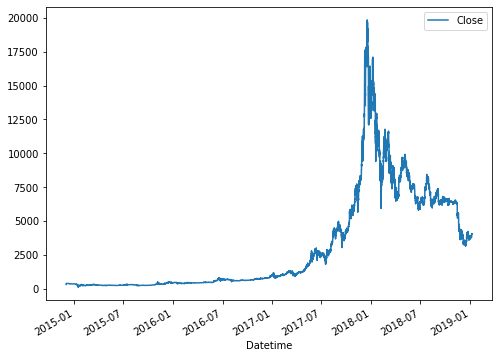

In [ ]:
plot_cols = ['Close']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

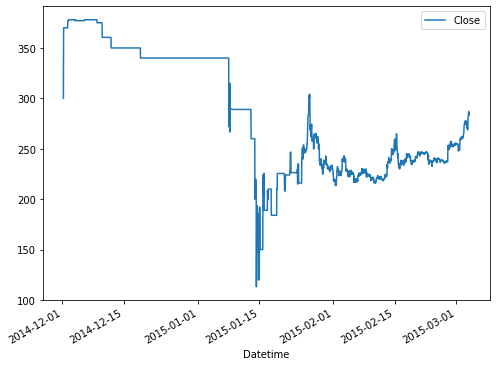

In [ ]:
plot_features = df[plot_cols][:2228]
plot_features.index = date_time[:2228]
_ = plot_features.plot(subplots=True)

In [ ]:
df['Log_return'] = np.log(df['Close']).diff()

In [ ]:
df.head()

,Close,Log_return
0,300.0,NaN
1,370.0,0.209721
2,370.0,0.000000
3,370.0,0.000000
4,370.0,0.000000


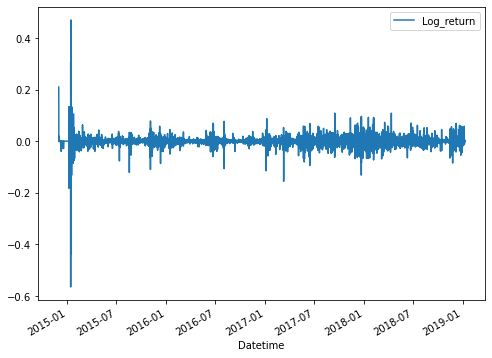

In [ ]:
plot_cols = ['Log_return']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

In [ ]:
df.pop('Log_return')

0             NaN
1        0.209721
2        0.000000
3        0.000000
4        0.000000
           ...   
35965    0.000107
35966    0.002100
35967   -0.004303
35968   -0.000037
35969   -0.000145
Name: Log_return, Length: 35970, dtype: float64

In [ ]:
df.head()

,Close
0,300.0
1,370.0
2,370.0
3,370.0
4,370.0


## Split data

In [ ]:
df.shape

(35970, 1)

In [ ]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

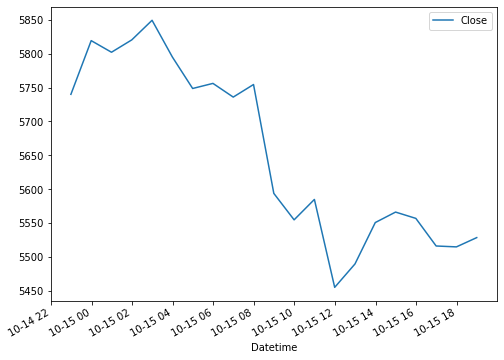

In [ ]:
plot_cols = ['Close']
plot_features = df[plot_cols].loc[int(n*0.7) - 10: int(n*0.7) + 10]
plot_features.index = date_time.loc[int(n*0.7) - 10:int(n*0.7) + 10]
_ = plot_features.plot(subplots=True)

In [ ]:
train_df.shape

(25179, 1)

### Normalize the data

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

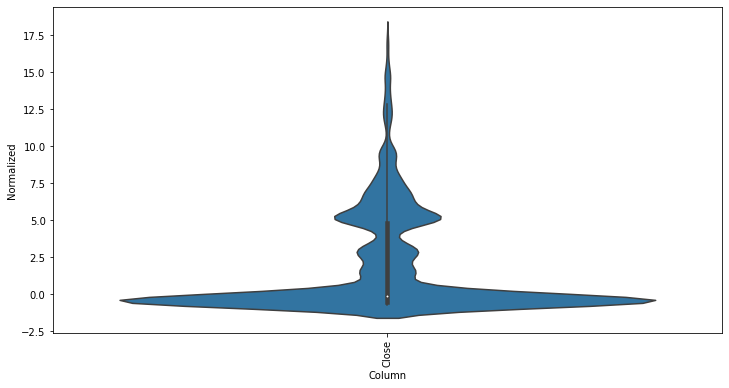

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

## Plot data

In [ ]:
def plot(self, model=None, plot_col='Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n + 1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices - 1, predictions[n, :, label_col_index],
                  marker='p', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [ ]:
save_ds = []
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  print("===================================================================")
  print(data.shape)
  print("===================================================================")
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  global save_ds 
  save_ds.append(ds)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## RNN

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Close'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Close']

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

(25179, 1)
Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

(25179, 1)
(7194, 1)
Epoch 1/50
787/787 [==============================] - 14s 15ms/step - loss: 0.0451 - mean_absolute_error: 0.0733 - val_loss: 10.4721 - val_mean_absolute_error: 2.1997
Epoch 2/50
787/787 [==============================] - 11s 14ms/step - loss: 0.0026 - mean_absolute_error: 0.0164 - val_loss: 6.5529 - val_mean_absolute_error: 1.5394
Epoch 3/50
787/787 [==============================] - 11s 14ms/step - loss: 3.7775e-04 - mean_absolute_error: 0.0088 - val_loss: 6.0509 - val_mean_absolute_error: 1.4506
Epoch 4/50
787/787 [==============================] - 12s 15ms/step - loss: 3.0148e-04 - mean_absolute_error: 0.0073 - val_loss: 5.9091 - val_mean_absolute_error: 1.4374
Epoch 5/50
787/787 [==============================] - 11s 14ms/step - loss: 2.7724e-04 - mean_absolute_error: 0.0068 - val_loss: 5.7149 - val_mean_absolute_error: 1.4009
Epoch 6/50
787/787 [==============================] - 11s 15ms/step - loss: 2.6098e-04 - mean_absolute_error: 0.0065 - val_loss: 5.5817 

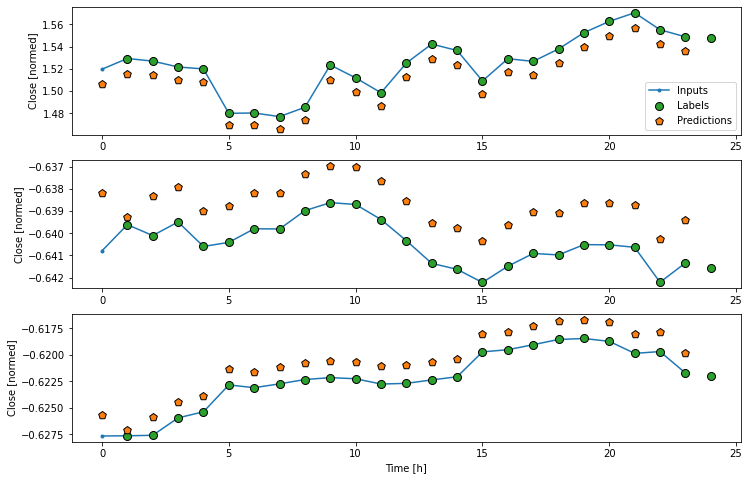

In [ ]:
wide_window.plot(lstm_model)

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
# tfds.as_dataframe(save_ds[-2].take(4), ("Hello", "you"))

In [ ]:
data_ = tfds.as_numpy(save_ds[-2])

In [ ]:
data_

In [ ]:
# Code to understand the tensorflow/keras dataset
i = 0
limit = 2
for ele in data_:
  print(ele[1].shape)
  i += 1
  if i == limit:
    break
print(i)

In [ ]:
print(ele[0].shape)
print(ele[1].shape)
my_num = ele[0][0][1][0]
my_num

(32, 24, 1)
(32, 24, 1)


-0.5939172

In [ ]:
my_num = train_df.head(1).iloc[0][0]
my_num

-0.5836778667669404

In [ ]:
my_num = -0.583678

In [ ]:
train_df.loc[train_df['Close'] == my_num]

,Close


In [ ]:
input = my_num
train_df.iloc[(train_df['Close']-input).abs().argsort()[:10]]

,Close
0,-0.583678
1347,-0.583678
1350,-0.583678
7947,-0.583706
5353,-0.583929
7957,-0.583408
7958,-0.583380
5352,-0.583985
1348,-0.583306
5355,-0.583213


In [ ]:
lstm_model.input_shape

(None, 24, 1)

In [ ]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 32)            4352      
_________________________________________________________________
dense (Dense)                (None, 24, 1)             33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
prediction1 = lstm_model.predict(
    tf.keras.preprocessing.timeseries_dataset_from_array(
      data=train_df,
      targets=None,
      sequence_length=wide_window.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)
)

In [ ]:
prediction1.shape

(25155, 25, 1)

In [ ]:
train_df.shape

(25179, 1)

In [ ]:
outputs1 = prediction1[:, -1:,:]
new_shape1 = (outputs1.shape[0], outputs1.shape[1])

In [ ]:
df_preds2_train = pd.DataFrame(
    data=outputs1.reshape(new_shape1),
    columns=['Predictions'],
)  

In [ ]:
df_preds_train = pd.DataFrame(np.nan, index=range(24), columns=['Predictions'])
df_preds_train = df_preds_train.append(df_preds2_train)
df_preds_train.reset_index(drop=True, inplace=True)
# df_preds_train.head(50)

In [ ]:
prediction1[0]

array([[-0.5833094 ],
       [-0.51709896],
       [-0.5179428 ],
       [-0.5175989 ],
       [-0.5176095 ],
       [-0.5175207 ],
       [-0.5174133 ],
       [-0.51734924],
       [-0.51732147],
       [-0.51731044],
       [-0.51730156],
       [-0.5172889 ],
       [-0.517272  ],
       [-0.5172527 ],
       [-0.5172332 ],
       [-0.51721513],
       [-0.5171995 ],
       [-0.5171866 ],
       [-0.5171763 ],
       [-0.5171683 ],
       [-0.5171622 ],
       [-0.5171576 ],
       [-0.51715404],
       [-0.5171514 ],
       [-0.5107373 ]], dtype=float32)

In [ ]:
train_df.iloc[23]

Close   -0.518578
Name: 23, dtype: float64

In [ ]:
prediction2 = lstm_model.predict(
    tf.keras.preprocessing.timeseries_dataset_from_array(
    data=val_df,
    targets=None,
    sequence_length=wide_window.total_window_size,
    sequence_stride=1,
    shuffle=False,
    batch_size=1,)
)

In [ ]:
prediction2.shape

(7170, 25, 1)

In [ ]:
outputs2 = prediction2[:, -1:,:]
new_shape2 = (outputs2.shape[0], outputs2.shape[1])

In [ ]:
df_preds2_val = pd.DataFrame(
    data=outputs2.reshape(new_shape2),
    columns=['Predictions'],
)  
#df_preds2_val.head(50)

In [ ]:
df_preds_val = pd.DataFrame(np.nan, index=range(24), columns=['Predictions'])
df_preds_val = df_preds_val.append(df_preds2_val)
idx_start = val_df.index[0]
idx_end = val_df.index[-1]
df_preds_val['idxs'] = range(idx_start, idx_end + 1)
df_preds_val.set_index(keys='idxs', drop=True, inplace=True)
#df_preds_val.head(50)

In [ ]:
prediction3 = lstm_model.predict(
    tf.keras.preprocessing.timeseries_dataset_from_array(
    data=test_df,
    targets=None,
    sequence_length=wide_window.total_window_size,
    sequence_stride=1,
    shuffle=False,
    batch_size=1,)
)

In [ ]:
prediction3.shape

(3573, 25, 1)

In [ ]:
outputs3 = prediction3[:, -1:,:]
new_shape3 = (outputs3.shape[0], outputs3.shape[1])

In [ ]:
df_preds2_test = pd.DataFrame(
    data=outputs3.reshape(new_shape3),
    columns=['Predictions'],
)  
#df_preds2_test.head(50)

In [ ]:
df_preds_test = pd.DataFrame(np.nan, index=range(24), columns=['Predictions'])
df_preds_test = df_preds_test.append(df_preds2_test)
idx_start = test_df.index[0]
idx_end = test_df.index[-1]
df_preds_test['idxs'] = range(idx_start, idx_end + 1)
df_preds_test.set_index(keys='idxs', drop=True, inplace=True)
#df_preds_test.head(50)

In [ ]:
print(train_df.index[-1], test_df.index[0])

25178 32373


[]

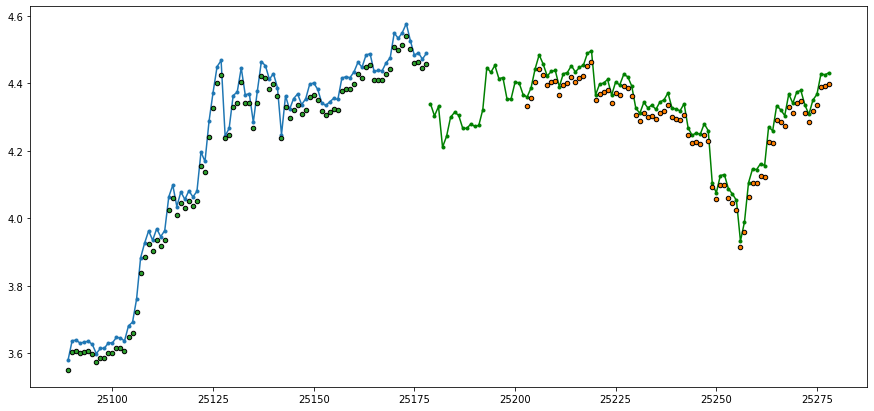

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(train_df.index[-90:], train_df[-90:],
             label='Train_inputs', marker='.', zorder=-10)
plt.plot(val_df.index[:100], val_df[:100],
             label='Test_inputs', marker='.', zorder=-10, color='green')

plt.scatter(df_preds_train.index[-90:], df_preds_train[-90:],
                edgecolors='k', label='Preds', c='#2ca02c', s=20)

plt.scatter(df_preds_val.index[:100], df_preds_val[:100],
                edgecolors='k', label='Preds', c='#FF8000', s=20)
plt.plot()

In [ ]:
final_df = (df.copy() - train_mean) / train_std

In [ ]:
final_prediction = lstm_model.predict(
    tf.keras.preprocessing.timeseries_dataset_from_array(
      data=final_df,
      targets=None,
      sequence_length=wide_window.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)
)

In [ ]:
final_prediction.shape

(35946, 25, 1)

In [ ]:
final_outputs = final_prediction[:, -1:,:]
new_shape_f = (final_outputs.shape[0], final_outputs.shape[1])

In [ ]:
df_preds2_final = pd.DataFrame(
    data=final_outputs.reshape(new_shape_f),
    columns=['Predictions'],
)  

In [ ]:
df_preds_final = pd.DataFrame(np.nan, index=range(24), columns=['Predictions'])
df_preds_final = df_preds_final.append(df_preds2_final)
df_preds_final.reset_index(drop=True, inplace=True)
df_preds_final.head(50)

,Predictions
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


In [ ]:
print(final_df.shape, df_preds_final.shape)

(35970, 1) (35970, 1)


In [ ]:
last_24 = final_df[-24:]

In [ ]:
final_df = (final_df * train_std) + train_mean
df_preds_final = (df_preds_final * train_std[0]) + train_mean[0]

In [ ]:
print(final_df.shape, df_preds_final.shape)

(35970, 1) (35970, 1)


[]

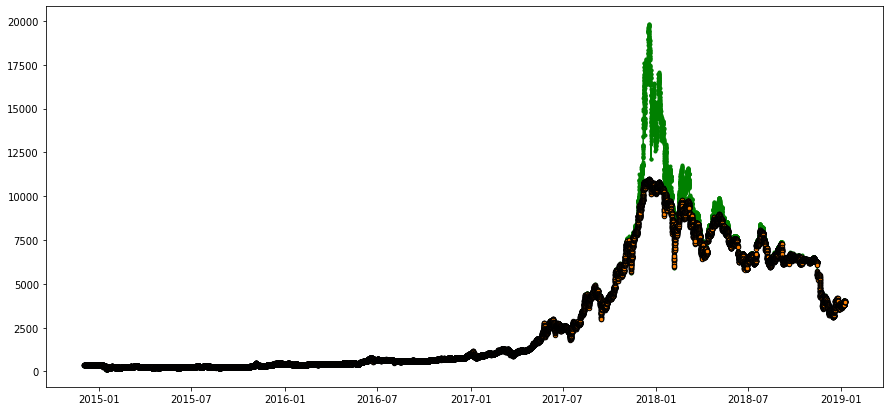

In [ ]:
s = 0
e = 95000050
plt.figure(figsize=(15, 7))
plt.plot(date_time[s:e], final_df[s:e],
             label='Total_inputs', marker='.', zorder=-10, color='green')

plt.scatter(date_time[s:e], df_preds_final[s:e],
                edgecolors='k', label='Preds', c='#FF8000', s=20)
plt.plot()

[]

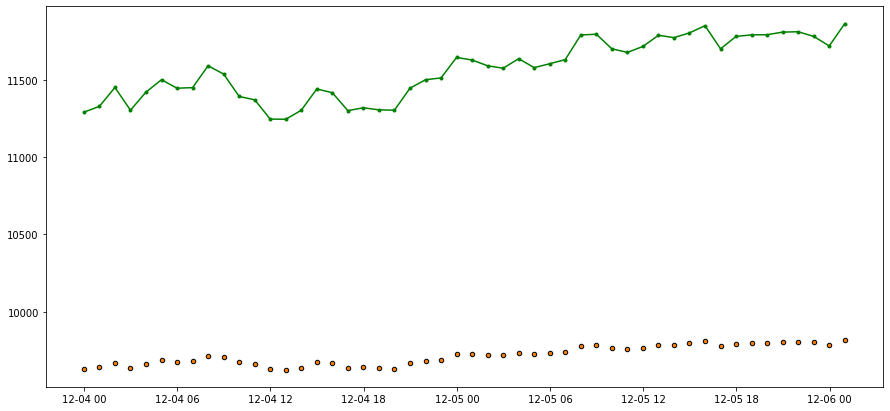

In [ ]:
s = -9600
e = -9550
plt.figure(figsize=(15, 7))
plt.plot(date_time[s:e], final_df[s:e],
             label='Total_inputs', marker='.', zorder=-10, color='green')

plt.scatter(date_time[s:e], df_preds_final[s:e],
                edgecolors='k', label='Preds', c='#FF8000', s=20)
plt.plot()

[]

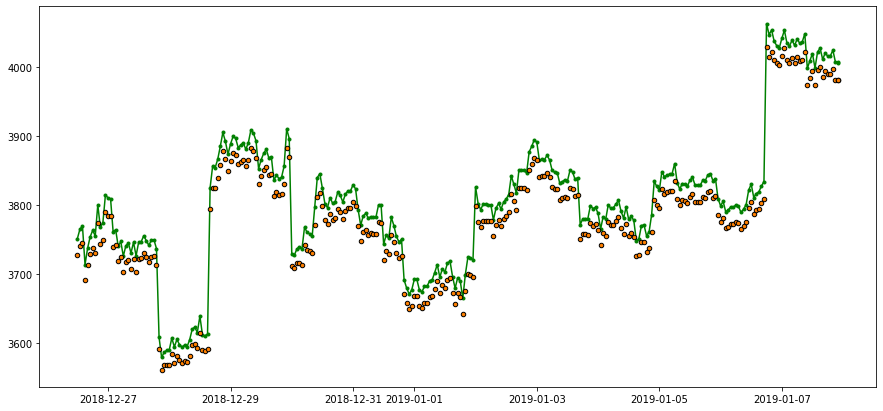

In [ ]:
s = -300
e = 955000
plt.figure(figsize=(15, 7))
plt.plot(date_time[s:e], final_df[s:e],
             label='Total_inputs', marker='.', zorder=-10, color='green')

plt.scatter(date_time[s:e], df_preds_final[s:e],
                edgecolors='k', label='Preds', c='#FF8000', s=20)
plt.plot()

In [ ]:
last_24_np = last_24.to_numpy()
last_24_np = last_24_np.reshape((1, last_24_np.shape[0], 1))
prediction_24 = lstm_model.predict(last_24_np) # (1, 24, 1) => (batch, time, feature)
end = prediction_24.reshape((24, 1))
end

array([[2.893365 ],
       [2.8769064],
       [2.8626723],
       [2.8594668],
       [2.8673158],
       [2.8616714],
       [2.870041 ],
       [2.8650846],
       [2.8665648],
       [2.8770351],
       [2.8325772],
       [2.842051 ],
       [2.85086  ],
       [2.831966 ],
       [2.8522794],
       [2.85748  ],
       [2.842845 ],
       [2.8513048],
       [2.8471694],
       [2.8473887],
       [2.8549268],
       [2.8397255],
       [2.8394532],
       [2.8389657]], dtype=float32)

[]

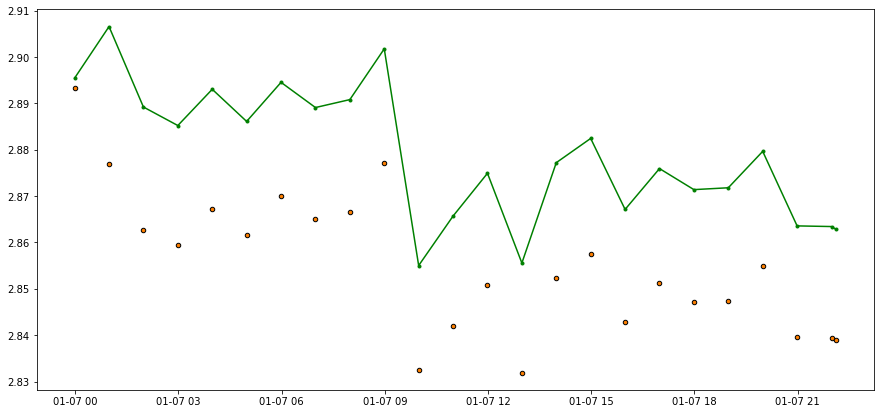

In [ ]:
s = -24
e = 955000
plt.figure(figsize=(15, 7))
plt.plot(date_time[s:e], last_24[s:e],
             label='Total_inputs', marker='.', zorder=-10, color='green')

plt.scatter(date_time[s:e], end,
                edgecolors='k', label='Preds', c='#FF8000', s=20)
plt.plot()